In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

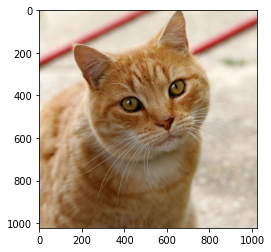

In [2]:
img = Image.open('./cat.jpg')
fig = plt.figure()
plt.imshow(img)

In [3]:
# resize to ImageNet size 
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # 添加 batch维度 / add dimension for batch
x.shape

torch.Size([1, 3, 224, 224])

In [4]:
class PatchEmbedding(nn.Module):
    """.
    1.patch embedding，把每个patch铺平
    2.对映射后的patches添加上cls token以及位置编码信息。
    3.加入Position Embadding添加位置信息，该信息由模型自己学习
    """
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
#             using a conv layer instead of a linear one -> performance gains
#             1.使用卷积层代替线性映射层把patch铺平
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
#         2.生成一个维度为emb_size的向量当做cls_token
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
#         3.位置编码信息，一共有(img_size // patch_size)**2 + 1(cls token)个位置向量
        self.positions = nn.Parameter(torch.randn((img_size // patch_size)**2 + 1, emb_size))
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        print(x.shape, self.positions.shape)
        x += self.positions
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768]) torch.Size([197, 768])


torch.Size([1, 197, 768])

In [5]:
# Attention
class MultiHeadAttention(nn.Module):
    """
    可以使用nn.MultiAttention模块，这里自己实现了一个MultiAttention
    1.定义了4个全连接层，分别用于queries, keys, values, 以及最后的线性映射层
      https://jalammar.github.io/illustrated-transformer/
      
    2.queries和keys之间的乘积来计算输入序列中的每一个patch与剩余patch之间的匹配程度。
      然后使用这个匹配程度(数值)去对对应的values做缩放，再累加起来作为Encoder的输出。
      
    3.forward方法将上一层的输出作为输入，使用三个线性映射层分别得到queries,keys,values。
      因为我们要实现multi-head注意力机制，我们需要将输出重排成多个head的形式。
      这一步是使用einops库的rearrange函数来完成的。
    """
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        print("1qkv's shape: ", self.qkv(x).shape)
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        print("2qkv's shape: ", qkv.shape)
        
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        print("queries's shape: ", queries.shape)
        print("keys's shape: ", keys.shape)
        print("values's shape: ", values.shape)
        
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        print("energy's shape: ", energy.shape)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        
        scaling = self.emb_size ** (1/2)
        print("scaling: ", scaling)
        att = F.softmax(energy, dim=-1) / scaling
        print("att1' shape: ", att.shape)
        att = self.att_drop(att)
        print("att2' shape: ", att.shape)
        
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        print("out1's shape: ", out.shape)
        out = rearrange(out, "b h n d -> b n (h d)")
        print("out2's shape: ", out.shape)
        out = self.projection(out)
        print("out3's shape: ", out.shape)
        return out
    
patches_embedded = PatchEmbedding()(x)
print("patches_embedding's shape: ", patches_embedded.shape)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768]) torch.Size([197, 768])
patches_embedding's shape:  torch.Size([1, 197, 768])
1qkv's shape:  torch.Size([1, 197, 2304])
2qkv's shape:  torch.Size([3, 1, 8, 197, 96])
queries's shape:  torch.Size([1, 8, 197, 96])
keys's shape:  torch.Size([1, 8, 197, 96])
values's shape:  torch.Size([1, 8, 197, 96])
energy's shape:  torch.Size([1, 8, 197, 197])
scaling:  27.712812921102035
att1' shape:  torch.Size([1, 8, 197, 197])
att2' shape:  torch.Size([1, 8, 197, 197])
out1's shape:  torch.Size([1, 8, 197, 96])
out2's shape:  torch.Size([1, 197, 768])
out3's shape:  torch.Size([1, 197, 768])


torch.Size([1, 197, 768])

In [8]:
class ResidualAdd(nn.Module):
    """
    残差连接
    """
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [9]:
class FeedForwardBlock(nn.Sequential):
    """
    前向传播层：包含两个线性层
    """
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [10]:
class TransformerEncoderBlock(nn.Sequential):
    """
    组合出Transformer的Encoder Block
    """
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [11]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768]) torch.Size([197, 768])
1qkv's shape:  torch.Size([1, 197, 2304])
2qkv's shape:  torch.Size([3, 1, 8, 197, 96])
queries's shape:  torch.Size([1, 8, 197, 96])
keys's shape:  torch.Size([1, 8, 197, 96])
values's shape:  torch.Size([1, 8, 197, 96])
energy's shape:  torch.Size([1, 8, 197, 197])
scaling:  27.712812921102035
att1' shape:  torch.Size([1, 8, 197, 197])
att2' shape:  torch.Size([1, 8, 197, 197])
out1's shape:  torch.Size([1, 8, 197, 96])
out2's shape:  torch.Size([1, 197, 768])
out3's shape:  torch.Size([1, 197, 768])


torch.Size([1, 197, 768])

In [12]:
class TransformerEncoder(nn.Sequential):
    """
    Transformer Encoder
    """
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [13]:
class ClassificationHead(nn.Sequential):
    """
    ViT的最后一层是一个简单的全连接层，输出分类的概率值。
    对整个序列执行一个mean操作。
    """
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [14]:
class ViT(nn.Sequential):
    """
    PatchEMbedding + TransformerEncoder + ClassificationHead → ViT
    """
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [15]:
# 计算参数量
# summary(ViT(), (3, 224, 224), device='cpu')

# ================================================================
# Total params: 107,676,904
# Trainable params: 107,676,904
# Non-trainable params: 0
# ----------------------------------------------------------------
# Input size (MB): 0.57
# Forward/backward pass size (MB): 405.89
# Params size (MB): 410.75
# Estimated Total Size (MB): 817.22
# ----------------------------------------------------------------